In [4]:
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pathlib import Path
from sklearn.preprocessing import StandardScaler

RELATIVE_FEATURES_DIR = '../data/features'
LANGUAGES = [                               # Languages to consider
    'ar',
    'en',
    'es',
    'ja',
    'pl',
    'ru',
    'sw',
    'tr',
    'uz',
    'yue',
    'zh-TW'
]
NO_OF_LANGUAGES = len(LANGUAGES)

In [5]:
def fix_array_format(arr_str):
    arr_str = re.sub(r"\s+", ",", arr_str.strip())
    arr_str = arr_str.replace("[,", "[").replace(",]", "]")
    return np.array(ast.literal_eval(arr_str))

def fix_list_values(df):
    list_columns = ['mfcc_mean', 'mfcc_var', 'spectral_contrast_mean', 'spectral_contrast_var', 'chroma_mean', 'chroma_var']
    for col in list_columns:
        features_df = df[col].apply(fix_array_format).apply(pd.Series)
        features_df.columns = [f'{col}_{i}' for i in range(features_df.shape[1])]
        df = pd.concat([df.drop(columns=[col]), features_df], axis=1)
    
    return df

In [6]:
# we need a dataset containing all the features of all languages, so array [x, 76] where x is the number of samples
all_languages_features = []
y = []

for language in LANGUAGES:
    file = Path(f'{RELATIVE_FEATURES_DIR}') / f'{language}_features.csv'
    scaler = StandardScaler()
    df = pd.read_csv(file).iloc[:, 3:]
    df = fix_list_values(df)

    X = df.to_numpy(dtype=float)

    scaled_X = scaler.fit_transform(X)
    all_languages_features.append(scaled_X)
    y.extend([file.stem.split('_')[0]] * scaled_X.shape[0])
    
# merge all languages features into one array
all_languages_features = np.concatenate(all_languages_features, axis=0)

In [7]:
print(all_languages_features.shape)

(250449, 76)


In [8]:
print(all_languages_features[0])

[ 0.30469834  0.15964809 -0.00656864 -0.47298932  2.81133538  3.38454523
  2.14788945  0.48228314  0.01919794 -0.12219391  3.78002087  4.92480751
 -1.00105453 -1.57626051  1.27602767  0.68673913 -0.41577601  1.50481911
 -1.21544802  1.33933897 -0.31158697  0.67905537  0.22094979 -0.31213006
 -0.21225374 -0.78149397 -0.85942337 -1.11918704 -0.22053813 -0.07074415
  0.2203941  -1.0131246  -0.11331924 -0.7774313  -1.33198837 -0.88721017
 -1.13704602 -0.6627706   0.14824168  0.00994626 -0.22732118 -1.03553789
 -0.89162864 -0.95239277  1.55324068  0.68191097  0.07587633  0.77551006
 -0.75005213 -0.29586147 -0.41955485 -0.76195085  1.64590607  1.03192577
  0.71374229  0.3178333   0.33291214  0.03684102  0.06752963  0.13547741
  0.27523369  0.76798359  1.23971286  1.65536637 -0.85890805 -0.84015991
 -0.70063002  0.10785807  1.02447366  0.39917843  0.22120589 -0.20862162
 -0.96546343 -1.29987773 -1.02146561 -1.28077086]


In [9]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

all_languages_features_df = pd.DataFrame(all_languages_features)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
all_languages_features_df = pd.DataFrame(imputer.fit_transform(all_languages_features_df))

# Initialize the 
model = LogisticRegression()

# Perform RFE
rfe = RFE(model, n_features_to_select=3)
fit = rfe.fit(all_languages_features_df, y)

# Get selected features
selected_features = all_languages_features_df.columns[fit.support_]
selected_features = all_languages_features_df[selected_features]

In [ ]:
print(selected_features)

              32        54        55
0      -0.113319  0.713742  0.317833
1      -1.125043  0.275704  0.478589
2      -0.251685  0.633876 -0.625273
3       0.613502  0.973734 -0.259717
4       0.600030 -1.313046 -1.381089
...          ...       ...       ...
250444  0.353849 -1.465025 -2.380158
250445  0.299676 -1.570097 -1.939527
250446  0.049682 -0.678097 -1.558810
250447  0.704855 -1.635477 -1.568961
250448  1.437128 -1.394972 -1.508226

[250449 rows x 3 columns]


In [11]:
print(selected_features.shape)

(250449, 3)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


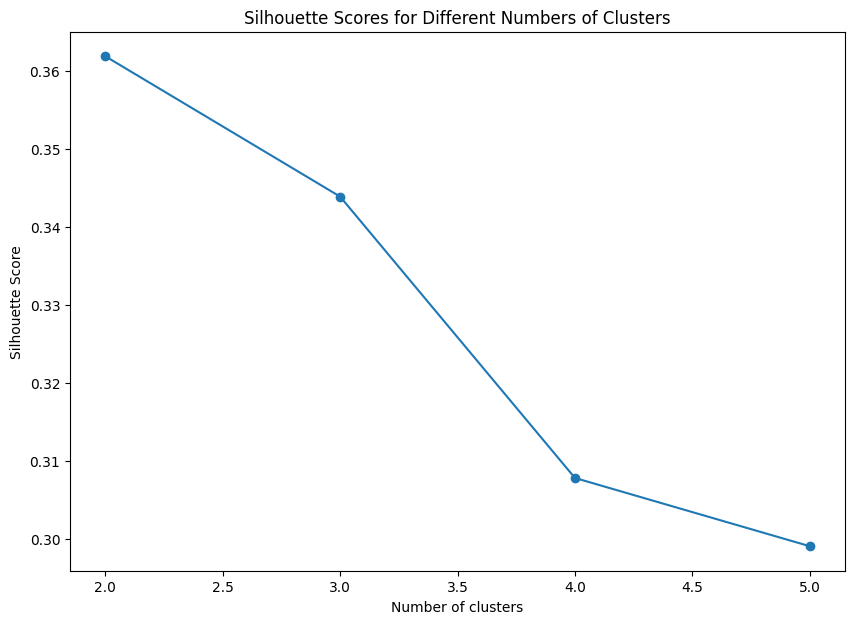

In [12]:
range_n_clusters = range(2, NO_OF_LANGUAGES)
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(selected_features)
    silhouette_avg = silhouette_score(selected_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores to visualize the optimal number of clusters
plt.figure(figsize=(10, 7))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.show()


In [25]:
print(NO_OF_LANGUAGES)

# print names of selected features
print(selected_features.columns)

df = pd.read_csv(f'{RELATIVE_FEATURES_DIR}/ab_features.csv').iloc[:, 3:]
df = fix_list_values(df)

6
Index([32, 54, 55], dtype='int64')
pitch_mean


In [30]:
# print columns of selected features
print(df.columns[32])
print(df.columns[54])
print(df.columns[55])

mfcc_var_7
chroma_mean_2
chroma_mean_3


#K-means
#DBSCAN
#Hierarchiczna
#Gaussian mixture model